In [1]:
from functional import *

import gymnasium as gym
from gymnasium import spaces
from typing import Any, Dict, List, Optional, Type
import torch as th
from torch import nn
from stable_baselines3.common.policies import BasePolicy
from stable_baselines3.common.torch_layers import (
    BaseFeaturesExtractor,
    CombinedExtractor,
    FlattenExtractor,
    NatureCNN,
    create_mlp,
)
from stable_baselines3.common.type_aliases import PyTorchObs, Schedule

2024-10-20 21:34:08.867550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-20 21:34:08.884204: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-20 21:34:08.888329: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-20 21:34:08.900359: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-20 21:34:09.867988: W tensorflow/compiler/tf2

In [2]:
class LSTMExtractor(BaseFeaturesExtractor):    
    def __init__(self, observation_space: gym.Space, lstm_hidden_size=128, lstm_num_layers=1, lstm_dropout=0.0):
        super().__init__(observation_space, lstm_hidden_size)
        
        input_size = observation_space.shape[1]
        
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=lstm_hidden_size, 
                            num_layers=lstm_num_layers, 
                            batch_first=True, 
                            dropout=lstm_dropout)
        
    def forward(self, observations: th.Tensor) -> th.Tensor:
        lstm_out, (h_n, c_n) = self.lstm(observations)
        return h_n[-1]


In [3]:
class QNetwork(BasePolicy):
    def __init__(self,
        observation_space: spaces.Space,
        action_space: spaces.Discrete,
        features_extractor:BaseFeaturesExtractor,
        features_dim: int,
        net_arch=None,
        activation_fn=nn.ReLU,
        normalize_images=True,
    ) -> None:
        super().__init__(
            observation_space,
            action_space,
            features_extractor=features_extractor,
            normalize_images=normalize_images,
        )

        if net_arch is None:
            net_arch = [64, 64]

        self.net_arch = net_arch
        self.activation_fn = activation_fn
        self.features_dim = features_dim
        action_dim = int(self.action_space.n)
        self.mlp = create_mlp(self.features_dim, action_dim, self.net_arch, self.activation_fn)
        self.q_net = nn.Sequential(*self.mlp)

    def forward(self, obs: PyTorchObs) -> th.Tensor:
        return self.q_net(self.extract_features(obs, self.features_extractor))

    def _predict(self, observation: PyTorchObs, deterministic: bool = True) -> th.Tensor:
        q_values = self(observation)
        action = q_values.argmax(dim=1).reshape(-1)
        return action

    def _get_constructor_parameters(self) -> Dict[str, Any]:
        data = super()._get_constructor_parameters()

        data.update(
            dict(
                net_arch=self.net_arch,
                features_dim=self.features_dim,
                activation_fn=self.activation_fn,
                features_extractor=self.features_extractor,
            )
        )
        return data


In [4]:
class DQNPolicy(BasePolicy):

    q_net: QNetwork
    q_net_target: QNetwork

    def __init__(
        self,
        observation_space: spaces.Space,
        action_space: spaces.Discrete,
        lr_schedule: Schedule,
        net_arch=None,
        activation_fn=nn.ReLU,
        features_extractor_class=FlattenExtractor,
        features_extractor_kwargs: Optional[Dict[str, Any]] = None,
        normalize_images: bool = True,
        optimizer_class: Type[th.optim.Optimizer] = th.optim.Adam,
        optimizer_kwargs=None,
    ) -> None:
        super().__init__(
            observation_space,
            action_space,
            features_extractor_class,
            features_extractor_kwargs,
            optimizer_class=optimizer_class,
            optimizer_kwargs=optimizer_kwargs,
            normalize_images=normalize_images,
        )

        if net_arch is None:
            if features_extractor_class == NatureCNN:
                net_arch = []
            else:
                net_arch = [64, 64]

        self.net_arch = net_arch
        self.activation_fn = activation_fn

        self.net_args = {
            "observation_space": self.observation_space,
            "action_space": self.action_space,
            "net_arch": self.net_arch,
            "activation_fn": self.activation_fn,
            "normalize_images": normalize_images,
        }

        self._build(lr_schedule)

    def _build(self, lr_schedule: Schedule) -> None:

        self.q_net = self.make_q_net()
        self.q_net_target = self.make_q_net()
        self.q_net_target.load_state_dict(self.q_net.state_dict())
        self.q_net_target.set_training_mode(False)

        self.optimizer = self.optimizer_class(self.q_net.parameters(),lr=lr_schedule(1),**self.optimizer_kwargs,)

    def make_q_net(self) -> QNetwork:
        net_args = self._update_features_extractor(self.net_args, features_extractor=None)
        return QNetwork(**net_args).to(self.device)

    def forward(self, obs: PyTorchObs, deterministic: bool = True,*args) -> th.Tensor:
        return self._predict(obs, deterministic=deterministic)

    def _predict(self, obs: PyTorchObs, deterministic: bool = True) -> th.Tensor:
        return self.q_net._predict(obs, deterministic=deterministic)

    def _get_constructor_parameters(self) -> Dict[str, Any]:
        data = super()._get_constructor_parameters()

        data.update(dict(
                net_arch=self.net_args["net_arch"],
                activation_fn=self.net_args["activation_fn"],
                lr_schedule=self._dummy_schedule,
                optimizer_class=self.optimizer_class,
                optimizer_kwargs=self.optimizer_kwargs,
                features_extractor_class=self.features_extractor_class,
                features_extractor_kwargs=self.features_extractor_kwargs,
            ))
        return data

    def set_training_mode(self, mode: bool) -> None:
        self.q_net.set_training_mode(mode)
        self.training = mode

In [5]:
policy_kwargs=dict(
    net_arch=[100,50,20,10,5,3],
    features_extractor_class=LSTMExtractor,
    activation_fn=nn.LeakyReLU,
)
dqn=agent('DQN',DQNPolicy,total_timesteps=10000,**policy_kwargs)

/home/golderalex2/Downloads/statistic/python/reinforce_trading/trading_environment.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Diff_pct']=self.df['Close'].pct_change(1).fillna(0)*100
/home/golderalex2/Downloads/statistic/python/reinforce_trading/trading_environment.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Diff_pct']=self.df['Close'].pct_change(1).fillna(0)*100


Using custom/other policy !!
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [6]:
dqn.learn()

/py_virtual/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 70.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 578      |
|    time_elapsed     | 6        |
|    total_timesteps  | 4012     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.234    |
|    n_updates        | 977      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 363      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 594      |
|    time_elapsed     | 13       |
|    total_timesteps  | 8024     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.847    |
|    n_updates      

In [7]:
dqn.evaluate()

/py_virtual/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.total to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.total` for environment variables or `env.get_wrapper_attr('total')` that will search the reminding wrappers.
  logger.warn(


Max drawdown      61.936900
PnL             7104.491533
ROI               71.044915
dtype: float64

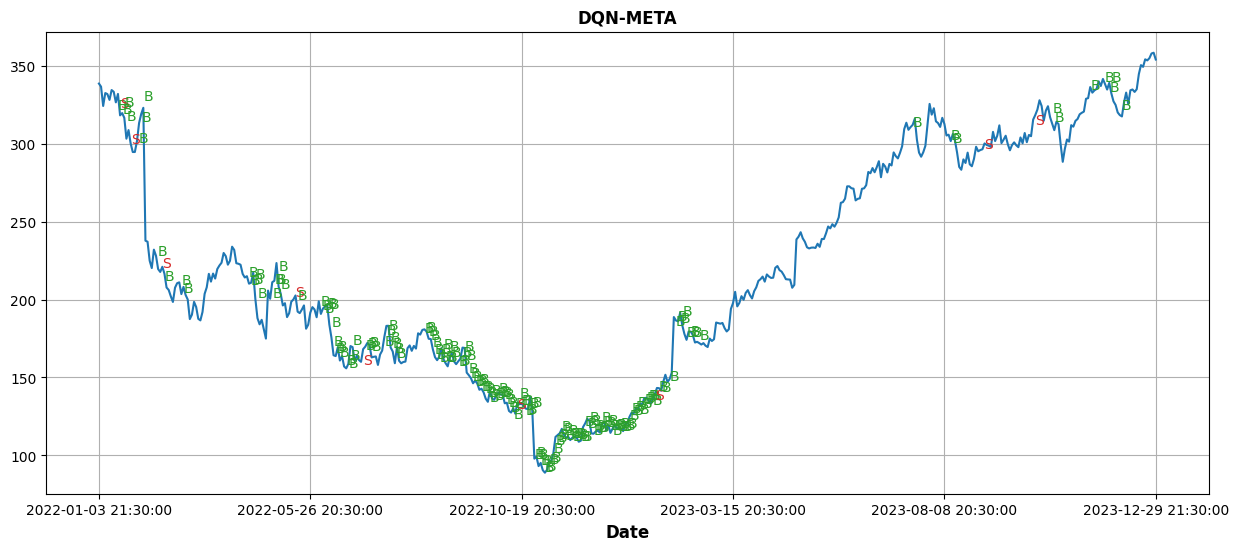

In [8]:
dqn.visualize()